<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/Paper_Original_(Xception)_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Benchmark CNN Model**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook ใช้สำหรับการ Train CNN Model

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com

## **Section 0: Import important library**

In [1]:
import os
import itertools
import time
from psutil import virtual_memory

import pandas as pd
import numpy as np
import random as rd

import tensorflow as tf
import keras
os.environ["KERAS_BACKEND"] = "tensorflow"
import sklearn
import joblib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import seaborn as sns
import cv2
import albumentations as A

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


In [5]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} gigabytes of available RAM")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Tue Nov  4 06:07:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Section 1: Preparing the directory for dataset and model**

### **In G-Drive Directory**

In [6]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
INDEX_SETTING = f"{DRIVE_DIR}/datasets/indexSetting"

In [7]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

In [8]:
MODEL_PATH = f"{DRIVE_DIR}/models" # <= สำหรับเก็บ Log Model ต่าง ๆ
MODEL_NAME = "XceptionPaper" # <= Model อะไร
OPTIMIZER_NAME = "Adam" # <= Optimizer อะไร
TYPE = "FineTuning" # <= FineTuning หรือ FeatureExtraction
ROUND_NUM = 1 # <= รันครั้งที่เท่าไหร่
MODEL_FULL_PATH = f"{MODEL_PATH}/{MODEL_NAME}_{TYPE}_{OPTIMIZER_NAME}_{ROUND_NUM}"
ASSETS_FOR_MODEL_PATH = f"{MODEL_FULL_PATH}/assets" # <= สำหรับเก็บรูปภาพต่าง ๆ จากโมเดล

MODEL_CODE_NAME = "Xception"
TYPE_CODE_NAME = "Based on Ref Paper"

os.makedirs(MODEL_FULL_PATH, exist_ok=True)
os.makedirs(ASSETS_FOR_MODEL_PATH, exist_ok=True)

In [9]:
MODEL_KERAS_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.keras"
MODEL_H5_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.h5"
MODEL_TFLITE_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}.tflite"
MODEL_CHECKPOINT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_best.keras"
MODEL_TENSORBOARD_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_tensorboard.logs"
MODEL_HISTORY_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_history.csv"
MODEL_JSON_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_json.json"
MODEL_REPORT_PATH = f"{MODEL_FULL_PATH}/{MODEL_NAME}_report.csv"

### **In Runtime Directory**

In [10]:
!unzip /content/drive/MyDrive/CP461/mainProject/datasets/ham10000Dataset.zip -d /content/ham10000Dataset

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: /content/ham10000Dataset/train/nv/ISIC_0030455.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0030406.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0031881.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0024531.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0031001.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0028637.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0032902.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0031327.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0032336.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0033818.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0028230.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0027493.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0033543.jpg  
  inflating: /content/ham10000Dataset/train/nv/ISIC_0033242.jpg  
  inflating: /conte

In [11]:
DATASET_DIR = "/content/ham10000Dataset"

## **Section 2: Preprocessing and augmentaion images**

### **Load dataset**

In [19]:
class TFDatasetPipeline:
    def __init__(self,
                 transform=None,
                 rescale=None,
                 preprocess_input=None):
        """
        Args:
            transform (albumentations.Compose, optional):
                Pipeline ของ Albumentations สำหรับ Augmentation
            preprocess_input (function, optional):
                ฟังก์ชัน Preprocessing ของโมเดล (เช่น resnet.preprocess_input)
                หากต้องการแค่ Rescale ให้ส่ง: 1./255
        """
        self.transform = transform
        self.rescale = rescale
        self.preprocess_input = preprocess_input
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.class_names = None

    def _build_class_names(self, df, y_cols, class_name_col, num_classes):
        if self.class_names is not None:
            return
        try:
            if class_name_col:
                mapping_df = df[[y_cols, class_name_col]].drop_duplicates().sort_values(by=y_cols)
                self.class_names = mapping_df[class_name_col].tolist()
                if len(self.class_names) != num_classes:
                    print(f"[Warning] Found {len(self.class_names)} class names but expected {num_classes}.")
            else:
                raise ValueError
        except Exception:
            print(f"[Warning] Could not extract class names. Using numeric labels instead.")
            self.class_names = [str(i) for i in range(num_classes)]

        print(f"Class indices: {dict(enumerate(self.class_names))}")

    def _transform_function(self, img_numpy):
        if self.transform is None:
            return img_numpy.astype(np.float32)

        img_uint8 = np.clip(img_numpy, 0, 255).astype(np.uint8)

        raw_img = {"image": img_uint8}
        transformed = self.transform(**raw_img)
        img_out = transformed["image"]

        if img_out.ndim == 2:
            img_out = np.stack([img_out] * 3, axis=-1)

        return img_out.astype(np.float32)

    @tf.function
    def _apply_transform(self, img_tensor, img_size):
        transformed = tf.numpy_function(
            func=self._transform_function,
            inp=[img_tensor],
            Tout=tf.float32
        )
        transformed.set_shape([*img_size, 3])
        return transformed

    def _load_and_resize(self, filepath, metadata, label, img_size):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, metadata, label

    def _process_image(self, img, is_training, img_size):
        if is_training and self.transform:
            img = self._apply_transform(img, img_size)

        if self.preprocess_input:
            img = self.preprocess_input(img)
        elif self.rescale:
            img = img * self.rescale

        return img

    def _process_label(self, label, num_classes, class_mode):
        label = tf.cast(label, tf.int32)
        if class_mode == "categorical":
            label = tf.one_hot(label, num_classes)
        elif class_mode != "sparse":
            raise ValueError(f"Unknown class_mode: {class_mode}")
        return label

    def _finalize_data(self, img, metadata, label,
                       num_classes, img_size, is_training, class_mode,
                       meta_shape):
        img = self._process_image(img, is_training, img_size)
        label = self._process_label(label, num_classes, class_mode)

        if meta_shape == 0:
            return img, label
        else:
            metadata = tf.cast(metadata, tf.float32)
            metadata.set_shape([meta_shape])
            return ((img, metadata), label)

    def flow_from_dataframe(
        self,
        df,
        X_cols,
        X_meta=None,
        y_cols=None,
        num_classes=None,
        class_name_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical",
        is_training=False,
        seed=42
    ):

        self._build_class_names(df, y_cols, class_name_col, num_classes)
        num_files = len(df)
        print(f"Found {num_files} files belonging to {num_classes} classes.")

        if X_meta is None:
            X_meta_data = [None] * num_files
            meta_shape = 0
        else:
            X_meta_data = X_meta.values
            meta_shape = X_meta_data.shape[1]
            print(f"[Info] Detected meta_shape={meta_shape} from input DataFrame.")

        dataset = tf.data.Dataset.from_tensor_slices(
            (df[X_cols].values, X_meta_data, df[y_cols].values)
        )

        dataset = dataset.map(
            lambda f, m, l: self._load_and_resize(f, m, l, target_size),
            num_parallel_calls=self.AUTOTUNE
        )
        dataset = dataset.cache()

        if is_training:
            dataset = dataset.shuffle(buffer_size=num_files, seed=seed, reshuffle_each_iteration=True)

        dataset = dataset.map(
            lambda img, m, l: self._finalize_data(
                img, m, l, num_classes, target_size,
                is_training, class_mode,
                meta_shape=meta_shape
            ),
            num_parallel_calls=self.AUTOTUNE
        )

        dataset = dataset.batch(batch_size).prefetch(self.AUTOTUNE)
        return dataset

In [20]:
df_train = pd.read_csv(f"{INDEX_SETTING}/metadata_train_original.csv")
df_val = pd.read_csv(f"{INDEX_SETTING}/metadata_val_original.csv")
df_test = pd.read_csv(f"{INDEX_SETTING}/metadata_test_original.csv")

transforms = A.Compose([
    A.Affine(
        rotate=(-20, 20),
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        shear=(-11, 11),
        scale=(0.8, 1.2),
        border_mode=cv2.BORDER_REFLECT_101,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
], seed=SEED)

In [21]:
def select_preprocess_input(model_name):
    if model_name == "EfficientNetV2B0":
        preprocess_input = keras.applications.efficientnet_v2.preprocess_input
        decode_predictions = keras.applications.efficientnet_v2.decode_predictions
    elif model_name == "MobileNetV3Large" or model_name == "MobileNetV3Small":
        preprocess_input = keras.applications.mobilenet_v3.preprocess_input
        decode_predictions = keras.applications.mobilenet_v3.decode_predictions
    elif model_name == "Xception":
        preprocess_input = keras.applications.xception.preprocess_input
        decode_predictions = keras.applications.xception.decode_predictions
    else:
        preprocess_input = None,
        decode_predictions = None
    return preprocess_input, decode_predictions

In [22]:
preprocess_fn, decode_pred = select_preprocess_input(MODEL_CODE_NAME)
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
INPUT_SHAPE = IMAGE_SIZE + (3, )
BATCH_SIZE = 16
EPOCHS = 30

In [23]:
class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
idx_to_class = {idx: name for idx, name in enumerate(class_names)}
NUM_CLASSES = len(class_names)
print(f"Index to class: {idx_to_class}")
print(f"Number of classes: {NUM_CLASSES}")

Index to class: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Number of classes: 7


In [24]:
pipeline = TFDatasetPipeline(
    transform=transforms,
    rescale=None,
    preprocess_input=preprocess_fn
)

In [25]:
ds_train = pipeline.flow_from_dataframe(
    df=df_train,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=True,
    batch_size=BATCH_SIZE,
    seed=SEED
)

ds_val = pipeline.flow_from_dataframe(
    df=df_val,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

ds_test = pipeline.flow_from_dataframe(
    df=df_test,
    X_cols="filepaths",
    X_meta=None,
    y_cols="cell_type_idx",
    num_classes=NUM_CLASSES,
    class_name_col="dx",
    is_training=False,
    batch_size=BATCH_SIZE
)

Class indices: {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
Found 8012 files belonging to 7 classes.
Found 1001 files belonging to 7 classes.
Found 1002 files belonging to 7 classes.


In [ ]:
'''# ดึง labels ของ training set
y_train = df_train["cell_type_idx"].values

# คำนวณ class weights
class_weights = sklearn.utils.class_weight.compute_class_weight(
    class_weight="balanced",  # "balanced" จะให้ weight ตาม inverse ของ frequency
    classes=np.unique(y_train),
    y=y_train
)

# แปลงเป็น dictionary {class_idx: weight}
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

print(class_weights_dict)'''

{0: np.float64(4.130102040816326), 1: np.float64(2.7210084033613446), 2: np.float64(1.3141233766233766), 3: np.float64(14.160349854227405), 4: np.float64(1.2524497163486332), 5: np.float64(0.21501615830714063), 6: np.float64(9.1296992481203)}


## **Section 3: Preparing the model**

### **Define callback function**

In [26]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,
    patience=5,
    mode="max",
    min_lr=1e-04,
    verbose=1
) # Reduce learning rate callback

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=MODEL_CHECKPOINT_PATH,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
) # Model checkpoint for save best model file

'''early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=10,
    verbose=1,
    restore_best_weights=False
) # Early stopping'''

tensorboard = keras.callbacks.TensorBoard(
    log_dir=MODEL_TENSORBOARD_PATH,
    histogram_freq=1,
    write_graph=True,
    write_images=True
) # Tensorboard file

callback_list = [reduce_lr, model_checkpoint, tensorboard]

### **Model parameters**

In [27]:
def build_model(input_shape, num_classes, model_name, trainable=False):
    image_input = keras.layers.Input(shape=input_shape, name="image_input")

    if model_name == "MobileNetV3Large":
        base_model = keras.applications.MobileNetV3Large(
            input_tensor=image_input,
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "EfficientNetV2B0":
        base_model = keras.applications.EfficientNetV2B0(
            input_tensor=image_input,
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "Xception":
        base_model = keras.applications.Xception(
            input_tensor=image_input,
            include_top=False,
            weights="imagenet"
        )

    else:
        raise ValueError(f"Unknown model_name: {model_name}. Supported: ['MobileNetV3Large', 'EfficientNetV2B0']")

    base_model.trainable = trainable

    image_features = keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    image_features = keras.layers.Dense(128, activation="relu", name="fc")(image_features)
    image_features = keras.layers.Dropout(0.5, name="dropout")(image_features)
    predictions = keras.layers.Dense(num_classes, activation="softmax", name="predictions")(image_features)

    model = keras.models.Model(inputs=image_input, outputs=predictions)
    return model

In [28]:
model = build_model(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    model_name=MODEL_CODE_NAME,
    trainable=True
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-03,
    ),
    loss = keras.losses.CategoricalCrossentropy(name="loss"),
    metrics = [
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.F1Score(name="f1_score", average="weighted"),
        keras.metrics.AUC(name="auc"),
        ]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ image_input[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,124,655 (80.58 MB)

 Trainable params: 21,070,127 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

## **Section 4: Training the model**

In [30]:
training_start = time.time()

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
)

training_end = time.time()
training_time = training_end - training_start
print(f"\n Training completed in {training_time:.4f} seconds")

Epoch 1/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6616 - auc: 0.9130 - f1_score: 0.5987 - loss: 1.0292 - precision: 0.8297 - recall: 0.5006
Epoch 1: val_accuracy improved from -inf to 0.66334, saving model to /content/drive/MyDrive/CP461/mainProject/models/XceptionPaper_FineTuning_Adam_1/XceptionPaper_best.keras
501/501 ━━━━━━━━━━━━━━━━━━━━ 184s 222ms/step - accuracy: 0.6617 - auc: 0.9130 - f1_score: 0.5988 - loss: 1.0290 - precision: 0.8298 - recall: 0.5007 - val_accuracy: 0.6633 - val_auc: 0.8881 - val_f1_score: 0.6492 - val_loss: 1.8345 - val_precision: 0.7077 - val_recall: 0.6144 - learning_rate: 0.0010
Epoch 2/30
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7187 - auc: 0.9444 - f1_score: 0.6759 - loss: 0.8181 - precision: 0.8378 - recall: 0.5983
Epoch 2: val_accuracy improved from 0.66334 to 0.74925, saving model to /content/drive/MyDrive/CP461/mainProject/models/XceptionPaper_FineTuning_Adam_1/XceptionPaper_best.keras
501/501 ━━━━━━━━━━━━━━━━━━━━ 114

### **Save the model config**

In [31]:
# Save model history
history_df = pd.DataFrame(history.history)
history_df.to_csv(MODEL_HISTORY_PATH, index=False)
print(f"History has been saved at {MODEL_HISTORY_PATH}")

# Save model file and tensorboard
model.save(MODEL_KERAS_PATH) # Keras format
print(f"Model keras format has been saved to: {MODEL_KERAS_PATH}")
model.save(MODEL_H5_PATH) # h5 format
print(f"Model h5 format has been saved to: {MODEL_H5_PATH}")
#model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load best weight model

History has been saved at /content/drive/MyDrive/CP461/mainProject/models/XceptionPaper_FineTuning_Adam_1/XceptionPaper_history.csv


Model keras format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/XceptionPaper_FineTuning_Adam_1/XceptionPaper.keras
Model h5 format has been saved to: /content/drive/MyDrive/CP461/mainProject/models/XceptionPaper_FineTuning_Adam_1/XceptionPaper.h5


In [40]:
model = keras.models.load_model(MODEL_CHECKPOINT_PATH) # Load model

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(MODEL_TFLITE_PATH, "wb") as f:
    f.write(tflite_model) # tflite format
    print(f"Model tflite format has been saved to: {MODEL_TFLITE_PATH}")

json_model = model.to_json() #Save as json format
with open(MODEL_JSON_PATH, "w") as json_file:
    json_file.write(json_model)
    print(f"Model json format has been saved to: {MODEL_JSON_PATH}")

Saved artifact at '/tmp/tmp7iwpt90i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image_input')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  140226145184336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145183184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145184144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145183760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145186064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145183376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145186832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145187216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145174160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145185104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140226145184720

## **Section 5: Evaluation the model**

In [42]:
results = model.evaluate(ds_test, return_dict=True)

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8386 - auc: 0.9725 - f1_score: 0.8437 - loss: 0.6487 - precision: 0.8399 - recall: 0.8379


In [43]:
loss = results["loss"]
accuracy = results["accuracy"]
precision = results["precision"]
recall = results["recall"]
f1_score = results["f1_score"]
auc = results["auc"]

print(f"--Final Test Results--")
print(f"Loss      : {loss:.4f}")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1_score:.4f}")
print(f"AUC       : {auc:.4f}")

--Final Test Results--
Loss      : 0.5786
Accuracy  : 0.8553
Precision : 0.8576
Recall    : 0.8533
F1 Score  : 0.8584
AUC       : 0.9739


In [44]:
y_pred_prob = model.predict(ds_test)

y_pred = np.argmax(y_pred_prob, axis=1)
y_pred_onehot = keras.utils.to_categorical(y_pred, num_classes=NUM_CLASSES)

y_true_batches = []
for images, labels in ds_test:
    y_true_batches.append(labels.numpy())

y_true_onehot = np.concatenate(y_true_batches, axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


In [45]:
print(f"y_pred shape: {y_pred.shape}")
print(f"y_true shape: {y_true.shape}")
print(f"y_pred_onehot shape: {y_pred_onehot.shape}")
print(f"y_true_onehot shape: {y_true_onehot.shape}")

y_pred shape: (1002,)
y_true shape: (1002,)
y_pred_onehot shape: (1002, 7)
y_true_onehot shape: (1002, 7)


### **Top-1 and Top-5 accuracy**

In [46]:
# Top-1 Accuracy and Error
top_1 = keras.metrics.TopKCategoricalAccuracy(k=1)
top_1.update_state(y_true_onehot, y_pred_prob)
top_1_acc = top_1.result().numpy()
top_1_err = 1 - top_1_acc
print(f"Top-1 Accuracy: {top_1_acc:.4f}")
print(f"Top-1 Error: {top_1_err:.4f}")

# Top-5 Accuracy and Error
top_5 = keras.metrics.TopKCategoricalAccuracy(k=5)
top_5.update_state(y_true_onehot, y_pred_prob)
top_5_acc = top_5.result().numpy()
top_5_err = 1 - top_5_acc
print(f"Top-5 Accuracy: {top_5_acc:.4f}")
print(f"Top-5 Error: {top_5_err:.4f}")

Top-1 Accuracy: 0.8553
Top-1 Error: 0.1447
Top-5 Accuracy: 0.9970
Top-5 Error: 0.0030


### **Classification Report**

In [47]:
report = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0,
    output_dict=True
)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(MODEL_REPORT_PATH, index=True)
report_df

,precision,recall,f1-score,support
akiec,0.823529,0.437500,0.571429,32.000000
bcc,0.836735,0.788462,0.811881,52.000000
bkl,0.676471,0.836364,0.747967,110.000000
df,0.900000,0.818182,0.857143,11.000000
mel,0.589928,0.732143,0.653386,112.000000
nv,0.951334,0.903130,0.926606,671.000000
vasc,0.928571,0.928571,0.928571,14.000000
accuracy,0.855289,0.855289,0.855289,0.855289
macro avg,0.815224,0.777764,0.785283,1002.000000
weighted avg,0.869853,0.855289,0.858423,1002.000000


### **Training and Validation curve**

In [48]:
def plot_history(history, save_path=None, fontsize=16, title=None):
    """
        สำหรับ Plot training and validation curve สำหรับ accuracy และ loss
        Args:
            history: ประวัติการ Train ที่ได้จาก model.fit()
            save_path: เซฟภาพเก็บไว้ที่ไหน (optional)
            fontsize: ขนาด font default 16
            title: สำหรับชื่อรูปภาพ (optional)
    """
    history_dict = history.history
    epochs = range(1, len(history_dict["accuracy"]) + 1)

    fig = plt.figure(figsize=(12, 5))

    # --Loss--
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict["loss"], "b-", label="Training loss")
    plt.plot(epochs, history_dict["val_loss"], "r-", label="Validation loss")
    plt.title("Training and validation loss", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Loss", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    # --Accuracy--
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict["accuracy"], "b-", label="Training accuracy")
    plt.plot(epochs, history_dict["val_accuracy"], "r-", label="Validation accuracy")
    plt.title("Training and validation accuracy", fontsize=fontsize)
    plt.xlabel("Epochs", fontsize=fontsize)
    plt.ylabel("Accuracy", fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)

    plt.tight_layout()

    if title:
        fig.text(0.5, 0.01, f"{title}", ha='center', fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/train_valid_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/train_valid_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

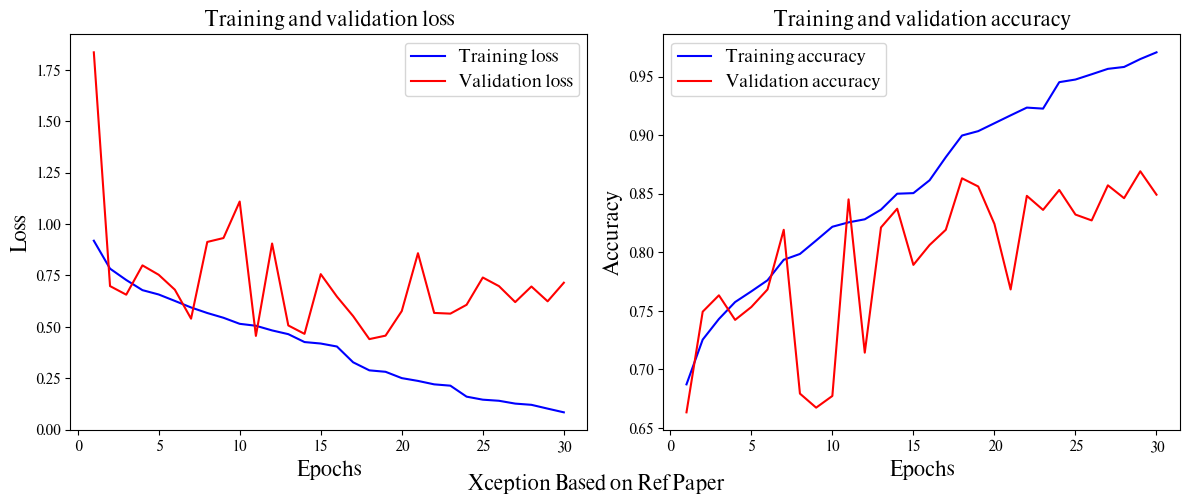

In [49]:
plot_history(history, save_path=ASSETS_FOR_MODEL_PATH, fontsize=14, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}")

### **Confusion Matrix**

In [50]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title=None, cmap=plt.cm.Blues,
                          save_path=None, fontsize=12):

    """
        สำหรับ Plot counfusion matrix
        Args:
            cm (array): ค่า confusion matrix ที่ต้องการ plot
            classes (list): รายชื่อคลาส (label names) สำหรับแกน X และ Y
            normalize (bool, default=False): ถ้า True จะทำ normalization ให้ค่าทุกแถวรวมเป็น 1
            title (str, optional): ชื่อกราฟที่จะแสดงด้านบน
            cmap (matplotlib colormap, default=plt.cm.Blues): โทนสีของ heatmap
            save_path (str, optional): โฟลเดอร์ที่จะบันทึกภาพ (ถ้าไม่กำหนดจะไม่บันทึก)
            fontsize (int, default=12): ขนาดตัวอักษรในกราฟ
    """
    correct_predictions = np.trace(cm)
    total_samples = np.sum(cm)
    accuracy = correct_predictions / total_samples
    misclassification_rate = 1 - accuracy

    if title:
        if normalize:
            pic_title = f"{title}\nConfusion Matrix (normalized)"
        else:
            pic_title = f"{title}\nConfusion Matrix"
    else:
        if normalize:
            pic_title = "Confusion Matrix (normalized)"
        else:
            pic_title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(pic_title, fontsize=fontsize, ha="center")
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=fontsize)
    plt.yticks(tick_marks, classes, fontsize=fontsize)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=fontsize,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=fontsize)
    metrics_text = (
        f"\nAccuracy: {accuracy:.4f}  |  Misclass: {misclassification_rate:.4f}"
    )
    plt.xlabel(f"Predicted label{metrics_text}", fontsize=fontsize)
    plt.tight_layout()

    if save_path:
        if normalize:
            plt.savefig(f"{save_path}/confusion_matrix_normalized.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix_normalized.svg", format="svg", bbox_inches="tight")
        else:
            plt.savefig(f"{save_path}/confusion_matrix.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}/confusion_matrix.svg", format="svg", bbox_inches="tight")

    plt.show()

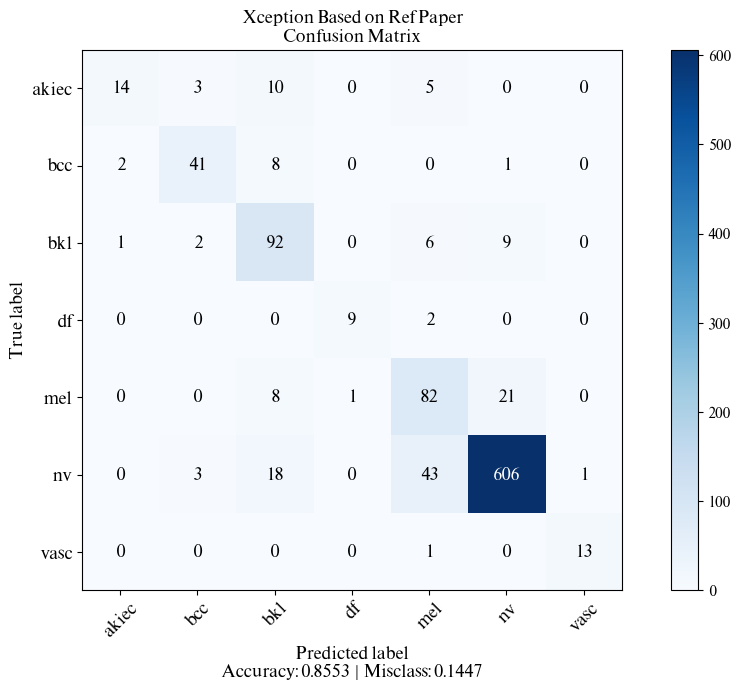

In [51]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
plot_confusion_matrix(cm, class_names, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", normalize=False, save_path=ASSETS_FOR_MODEL_PATH)

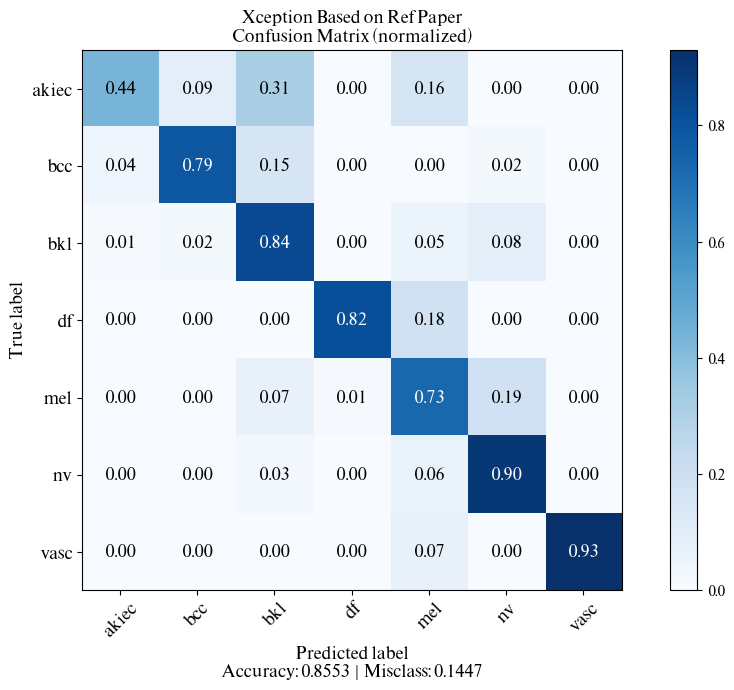

In [52]:
plot_confusion_matrix(cm, class_names, title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", normalize=True, save_path=ASSETS_FOR_MODEL_PATH)

### **Plot AUC-ROC Curve**

In [53]:
def plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, title=None, save_path=None, fontsize=14):
    """
        y_true_onehot (ndarray): ค่า ground truth ในรูปแบบ one-hot encoded (ขนาด n_samples × n_classes)
        y_pred_prob (ndarray): ค่าความน่าจะเป็นที่โมเดลทำนาย (ขนาดเดียวกันกับ y_true_onehot)
        class_names (list): รายชื่อคลาสแต่ละคลาสที่ใช้แสดงในกราฟ
        title (str, optional): ชื่อกราฟ (ถ้าไม่ระบุจะใช้ชื่อเริ่มต้น “Receiver Operating Characteristic (ROC) - Multiclass”)
        save_path (str, optional): โฟลเดอร์สำหรับบันทึกภาพ (.png และ .svg)
        fontsize (int, default=14): ขนาดตัวอักษรในกราฟ
    """
    n_classes = y_pred_prob.shape[1]
    plt.figure(figsize=(12, 7))

    if title:
        pic_title = f"{title}\nReceiver Operating Characteristic (ROC) - Multiclass"
    else:
        pic_title = "Receiver Operating Characteristic (ROC) - Multiclass"

    for i in range(n_classes):
        fpr, tpr, _ = sklearn.metrics.roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.4f})")

    fpr_micro, tpr_micro, _ = sklearn.metrics.roc_curve(y_true_onehot.ravel(), y_pred_prob.ravel())
    roc_auc_micro = sklearn.metrics.auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, color="deeppink", linestyle="--", lw=2,
             label=f"Micro-average (AUC = {roc_auc_micro:.4f})")

    roc_auc_macro = sklearn.metrics.roc_auc_score(y_true_onehot, y_pred_prob, average='macro')
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--",
             label=f"Macro-average (AUC = {roc_auc_macro:.4f})")

    plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle=":")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=fontsize)
    plt.ylabel("True Positive Rate", fontsize=fontsize)
    plt.title(pic_title, fontsize=fontsize)
    plt.legend(loc="lower right", fontsize=fontsize)
    plt.grid(alpha=0.3)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if save_path:
        plt.savefig(f"{save_path}/roc_auc_curve.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}/roc_auc_curve.svg", format="svg", bbox_inches="tight")

    plt.show()

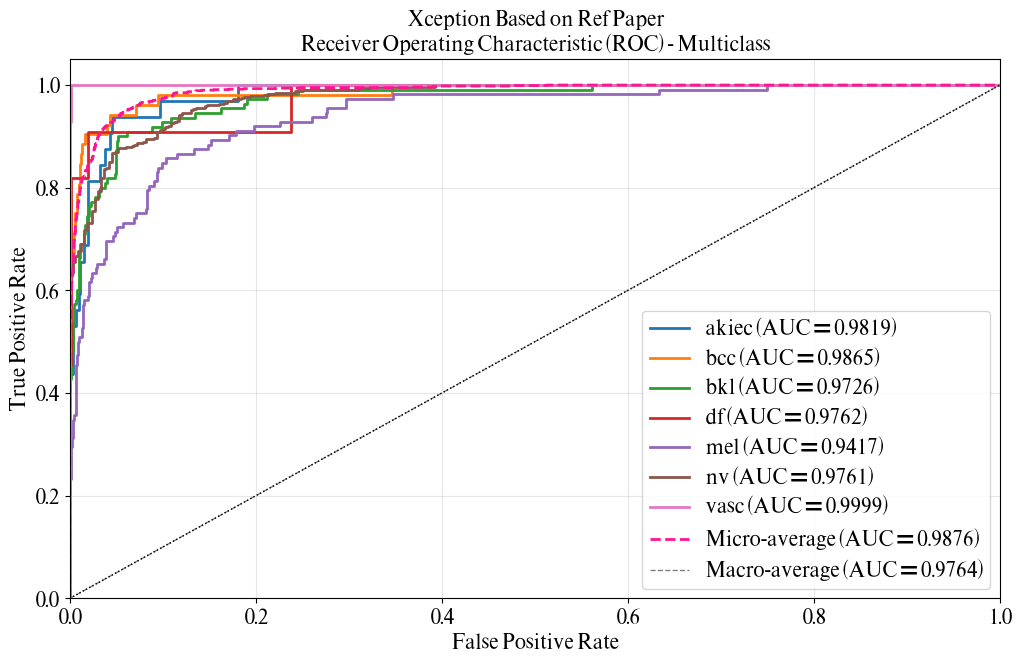

In [54]:
plot_multi_class_roc(y_true_onehot, y_pred_prob, class_names, f"{MODEL_CODE_NAME} {TYPE_CODE_NAME}", ASSETS_FOR_MODEL_PATH)

## **Section 6: XAI Explainable (AI)**

In [64]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def sample_one_per_class(df, label_col, n_classes=None, seed=42):
    """
    สุ่ม 1 ตัวอย่างต่อคลาสจาก DataFrame
    Args:
        df (pd.DataFrame): DataFrame เต็ม
        label_col (str): ชื่อ column ของ label
        n_classes (int, optional): จำนวนคลาสสูงสุดที่จะสุ่ม ถ้า None ใช้ทั้งหมด
        seed (int): random seed
    Returns:
        pd.DataFrame: DataFrame ของตัวอย่างที่สุ่มมา
    """
    sampled_df = df.groupby(label_col, group_keys=False)[df.columns].apply(
        lambda x: x.sample(1, random_state=seed)
    ).reset_index(drop=True)

    if n_classes is not None and len(sampled_df) > n_classes:
        sampled_df = sampled_df.sample(n=n_classes, random_state=seed)

    return sampled_df

In [65]:
LAST_CONV_LAYER = "block14_sepconv2_act"

In [103]:
def plot_gradcam_for_classes(
    df_test, X_cols, y_cols, model,
    last_conv_layer_name, idx_to_class, n_classes=7,
    alpha=0.4, img_size=(224, 224), seed=42, fontsize=12,
    title=None, heatmap_only=False, save_path=None,
    preprocess_input_fn=None
):
    """
    แสดง Grad-CAM ของแต่ละคลาส โดยสุ่มภาพ 1 ภาพต่อคลาสจาก df_test
    รองรับภาพที่ผ่าน preprocessing แล้วโดยไม่ต้อง normalize ภายใน
    """

    sampled_df = sample_one_per_class(df_test, y_cols, n_classes=n_classes, seed=seed)

    fig_width = max(12, 3 * len(sampled_df))
    fig, axes = plt.subplots(1, len(sampled_df), figsize=(fig_width, 5))
    if len(sampled_df) == 1:
        axes = [axes]

    if title is not None:
        fig.suptitle(title, fontsize=fontsize + 2, y=0.97)

    grad_model = keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    for ax, (_, row) in zip(axes, sampled_df.iterrows()):
        img_path = row[X_cols]
        true_class_idx = row[y_cols]
        img_array = get_img_array(img_path, size=img_size)
        if img_array.ndim == 3:
            img_array = np.expand_dims(img_array, axis=0)

        img_display = img_array[0].astype("float32")
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min() + 1e-7)
        img_preprocessed = preprocess_input_fn(img_array) if preprocess_input_fn else img_array

        preds = model.predict(img_preprocessed, verbose=0)
        pred_index = np.argmax(preds[0])
        confidence = preds[0][pred_index]

        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_preprocessed)
            loss = predictions[:, pred_index]

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs = conv_outputs[0]

        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) + keras.backend.epsilon()

        jet = plt.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        heatmap_uint8 = np.uint8(255 * heatmap)
        jet_heatmap = jet_colors[heatmap_uint8]
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap) / 255.0

        if heatmap_only:
            display_img = keras.utils.array_to_img(jet_heatmap)
        else:
            overlay_gain = 0.6
            superimposed = (img_display * (1 - alpha)) + (jet_heatmap * alpha * overlay_gain)
            superimposed = np.clip(superimposed, 0, 1)
            display_img = keras.utils.array_to_img(superimposed)

        true_class_name = idx_to_class[true_class_idx]
        pred_class_name = idx_to_class[pred_index]
        color = "green" if true_class_idx == pred_index else "red"

        ax.imshow(display_img)
        ax.axis("off")
        ax.set_title(
            f"True: {true_class_name}\nPred: {pred_class_name} ({confidence:.2f})",
            fontsize=fontsize, color=color
        )

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

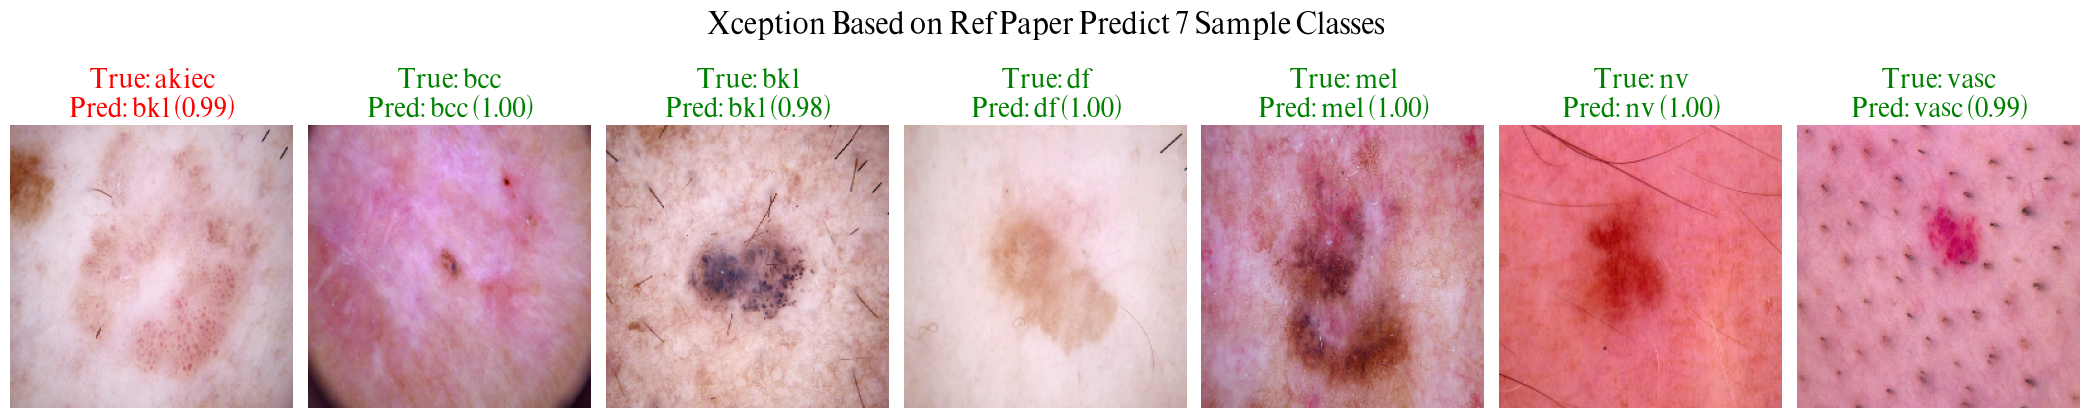

In [104]:
plot_gradcam_for_classes(
    df_test=df_test,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=0,
    img_size=IMAGE_SIZE,
    seed=1234,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Predict 7 Sample Classes",
    heatmap_only=False,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/predict",
    preprocess_input_fn=preprocess_fn
)

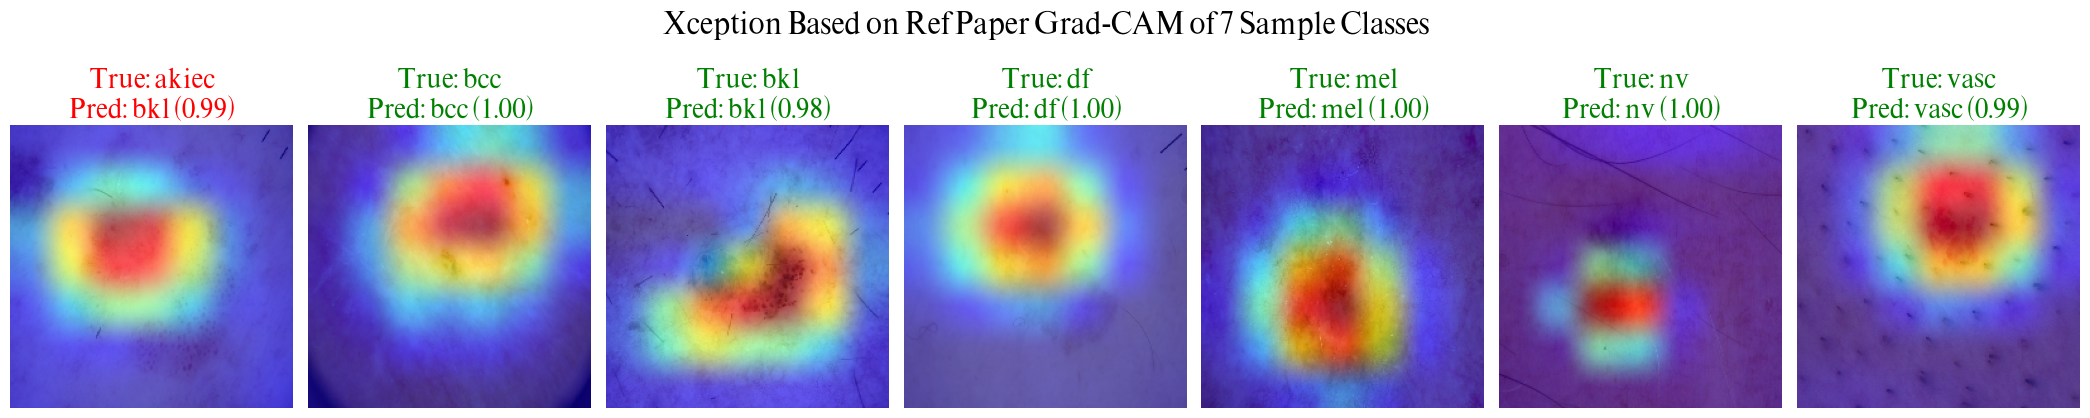

In [105]:
plot_gradcam_for_classes(
    df_test=df_test,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=0.7,
    img_size=IMAGE_SIZE,
    seed=1234,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Grad-CAM of 7 Sample Classes",
    heatmap_only=False,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/grad_cam",
    preprocess_input_fn=preprocess_fn
)

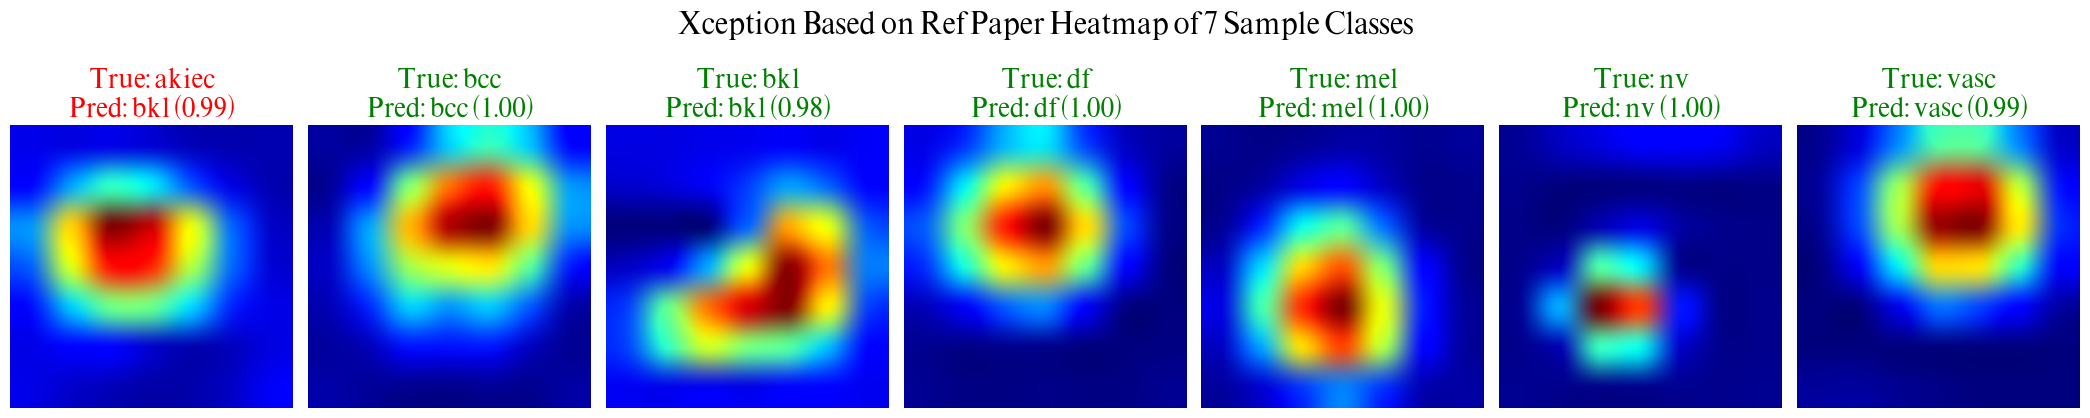

In [106]:
plot_gradcam_for_classes(
    df_test=df_test,
    X_cols="filepaths",
    y_cols="cell_type_idx",
    model=model,
    last_conv_layer_name=LAST_CONV_LAYER,
    idx_to_class=idx_to_class,
    n_classes=NUM_CLASSES,
    alpha=0,
    img_size=IMAGE_SIZE,
    seed=1234,
    fontsize=18,
    title=f"{MODEL_CODE_NAME} {TYPE_CODE_NAME} Heatmap of 7 Sample Classes",
    heatmap_only=True,
    save_path=f"{ASSETS_FOR_MODEL_PATH}/heatmap",
    preprocess_input_fn=preprocess_fn
)